# Load the Dataset

* annotated json files have to be stored in the `data/processed` dir.


In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..")))
import pandas as pd
import numpy as np
from scripts.features.reader import Reader
from scripts.features.post_feature import PostFeature
from scripts.features.length_extractor import TitleLengthExtractor, SectionCountExtractor


reader = Reader()
pf_dicts = []
for p in reader.post_iterator():
    pf = PostFeature(p)
    pf.add(TitleLengthExtractor())
    pf.add(SectionCountExtractor())
    pf_d = pf.to_dict(drop_disused_feature=False)  # default True -> drop title, body etc fields
    pf_dicts.append(pf_d)
    
pf_df = pd.DataFrame(pf_dicts)
pf_df.head(5)

,body,post_id,quality,section_count,title,title_length,url,user_followers_count,user_id
0,\n# Development Environment\n- OS X El Captain...,00a2a3dc557089d95ec0,0,3,"Intに数字の単位をつけて表示させたい (Ex. 1,000 -> 1K, 2,000,00...",54,http://qiita.com/law/items/00a2a3dc557089d95ec0,2,law
1,#gulp.spritesmith\n- CSS Spriteとそれに対応した scssファ...,0a0d29de9a2785d00ca0,0,8,CSS Sprite自動生成(gulp.spritesmith),32,http://qiita.com/hththt/items/0a0d29de9a2785d0...,24,hththt
2,ハマったのでメモ。\nまあRailsで１から作っている場合は遭遇しないかもしれませんが・・・...,0a1ed3bd751e117094a3,1,7,カラム型TINYINTの場合にActiveRecord::Enumを使いたい,38,http://qiita.com/SaxtonDrey/items/0a1ed3bd751e...,2,SaxtonDrey


In [27]:
# drop disused features
if "post_id" in pf_df.columns:
    pf_df.drop(pf_df[["post_id", "title", "body", "url", "user_id"]], axis=1, inplace=True)

quality = pf_df["quality"]
pf_df.drop("quality", axis=1, inplace=True)

In [28]:
# normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pf_df_n = scaler.fit_transform(pf_df)

/Users/smap6/.pyenv/versions/miniconda3-3.9.1/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
/Users/smap6/.pyenv/versions/miniconda3-3.9.1/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/smap6/.pyenv/versions/miniconda3-3.9.1/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/smap6/.pyenv/versions/miniconda3-3.9.1/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and 

[ 0.  0.]
             precision    recall  f1-score   support

        bad       0.00      0.00      0.00         1
       good       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         1



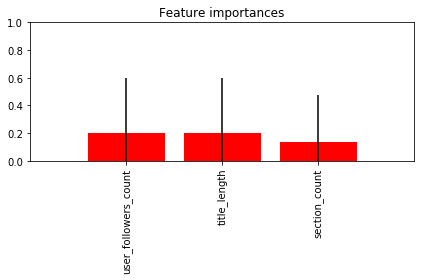

In [31]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# estimate accuracy by cross validation
clf = RandomForestClassifier(n_estimators=15, max_features=0.5)
scores = cross_val_score(clf, pf_df_n,  quality, cv=2, scoring="f1")
print(scores)

# train and show score
train_f, test_f, train_lb, test_lb = train_test_split(pf_df_n, quality, test_size=0.2, random_state=42)
clf.fit(train_f, train_lb)
pred = clf.predict(test_f)
print(classification_report(test_lb, pred, target_names=["bad", "good"]))

# show feature importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
labels = np.array(pf_df.columns.values.tolist())
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(labels)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(labels)), labels[indices], rotation="vertical")
plt.xlim([-1, len(labels)])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()